# Business Analytics project

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# --- Plot saver utility ---
from pathlib import Path
import matplotlib.pyplot as plt

def save_plot(filename: str, dpi: int = 300, tight: bool = True, folder: str = "images"):
    """
    Save the current matplotlib figure to images/<filename> with consistent settings.
    Usage: call *before* plt.show().
    """
    outdir = Path(folder)
    outdir.mkdir(parents=True, exist_ok=True)
    path = outdir / filename
    plt.savefig(path, dpi=dpi, bbox_inches='tight' if tight else None)
    print(f"Saved: {path}")

In [3]:
# load all datasets
visits = pd.read_csv('visits_log_us.csv')
orders = pd.read_csv('orders_log_us.csv')
costs = pd.read_csv('costs_us.csv')

### Quick check for memory usage and data types

In [4]:
print('Visits')
visits.info(memory_usage = 'deep')
print()
print('Orders')
orders.info(memory_usage = 'deep')
print()
print('Costs')
costs.info(memory_usage = 'deep')

Visits
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   Device     359400 non-null  object
 1   End Ts     359400 non-null  object
 2   Source Id  359400 non-null  int64 
 3   Start Ts   359400 non-null  object
 4   Uid        359400 non-null  uint64
dtypes: int64(1), object(3), uint64(1)
memory usage: 71.1 MB

Orders
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Buy Ts   50415 non-null  object 
 1   Revenue  50415 non-null  float64
 2   Uid      50415 non-null  uint64 
dtypes: float64(1), object(1), uint64(1)
memory usage: 4.0 MB

Costs
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     -----

### Cleaning & Typing

In [5]:
#visits.csv
visits['Device'] = visits['Device'].astype('category')
visits['End Ts'] =  pd.to_datetime(visits['End Ts'], errors = 'coerce')
visits['Start Ts'] =  pd.to_datetime(visits['Start Ts'], errors = 'coerce')
#orders.csv
orders['Buy Ts'] = pd.to_datetime(orders['Buy Ts'], errors = 'coerce')
#costs.csv
costs.rename(columns = {'dt': 'date'}, inplace = True)
costs['date'] = pd.to_datetime(costs['date'], errors = 'coerce')

### Check

In [6]:
print('Visits')
visits.info(memory_usage = 'deep')
print()
print('Orders')
orders.info(memory_usage = 'deep')
print()
print('Costs')
costs.info(memory_usage = 'deep')

Visits
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   Device     359400 non-null  category      
 1   End Ts     359400 non-null  datetime64[ns]
 2   Source Id  359400 non-null  int64         
 3   Start Ts   359400 non-null  datetime64[ns]
 4   Uid        359400 non-null  uint64        
dtypes: category(1), datetime64[ns](2), int64(1), uint64(1)
memory usage: 11.3 MB

Orders
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   Buy Ts   50415 non-null  datetime64[ns]
 1   Revenue  50415 non-null  float64       
 2   Uid      50415 non-null  uint64        
dtypes: datetime64[ns](1), float64(1), uint64(1)
memory usage: 1.2 MB

Costs
<class 'pandas.core.frame.DataFrame'>
RangeInde

### Checking for Duplicates

Сhecking for duplicates is one of the most important operation with datasets.  
If duplicates exist, we should decide whether to drop them or investigate why they appear.

In [7]:
# Visits
dpl_visits = visits.duplicated().sum()
print("Visits duplicates:", dpl_visits)

# Orders
dpl_orders = orders.duplicated().sum()
print("Orders duplicates:", dpl_orders)

# Costs
dpl_costs = costs.duplicated().sum()
print("Costs duplicates:", dpl_costs)

Visits duplicates: 0
Orders duplicates: 0
Costs duplicates: 0


### Interpretation — Duplicates Check

- The number of duplicates is **0**, the datasets are clean.  
- If we found duplicates we would drop them (in most cases):
  - In `visits` or `orders`: may indicate logging or merging issues → usually should be dropped.  
  - In `costs`: may represent repeated entries; verify whether they need to be aggregated or removed.

  using:
    visits = visits.drop_duplicates()
    orders = orders.drop_duplicates()
    costs = costs.drop_duplicates()


**Rule of thumb:** unless duplicates carry unique business meaning, they should be dropped to avoid double-counting in metrics.

# PRODUCT

## Product Metrics — Visits

Now that I've prepared all the datasets, let’s calculate the key `product` metrics:

1. ***DAU / WAU / MAU*** — number of unique active users per day, week, and month.  
2. ***Sessions per day*** — one user may have more than one session per day.  
3. ***Session length*** — average and distribution of session duration.  
4. ***Retention rate*** — share of users who return in subsequent periods (weekly cohorts).

1. ***DAU / WAU / MAU***

In [8]:
dau = visits.groupby(visits['Start Ts'].dt.date)['Uid'].nunique()
wau = visits.groupby(visits['Start Ts'].dt.to_period('W'))['Uid'].nunique()
mau = visits.groupby(visits['Start Ts'].dt.to_period('M'))['Uid'].nunique()

In [9]:
print("Average DAU: ", dau.mean())
print("Average WAU: ", wau.mean())
print("Average MAU: ", mau.mean())

Average DAU:  907.9917582417582
Average WAU:  5716.245283018868
Average MAU:  23228.416666666668


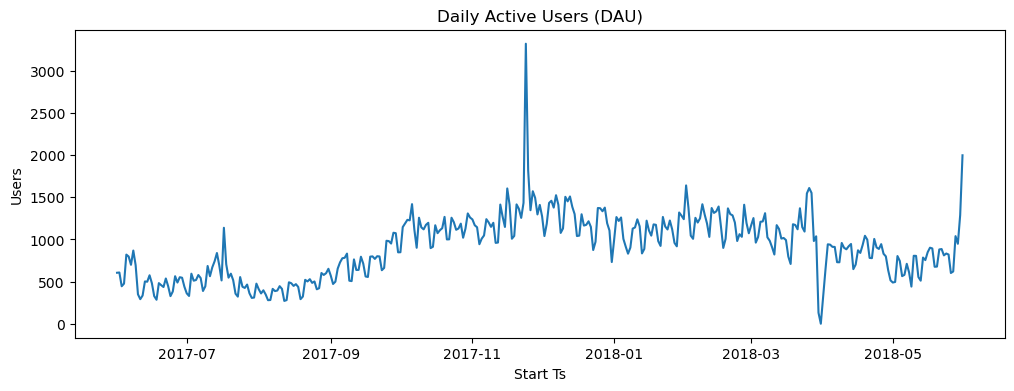

In [10]:
# Plot DAU
dau.plot(figsize=(12,4), title="Daily Active Users (DAU)")
plt.ylabel("Users")
plt.show()

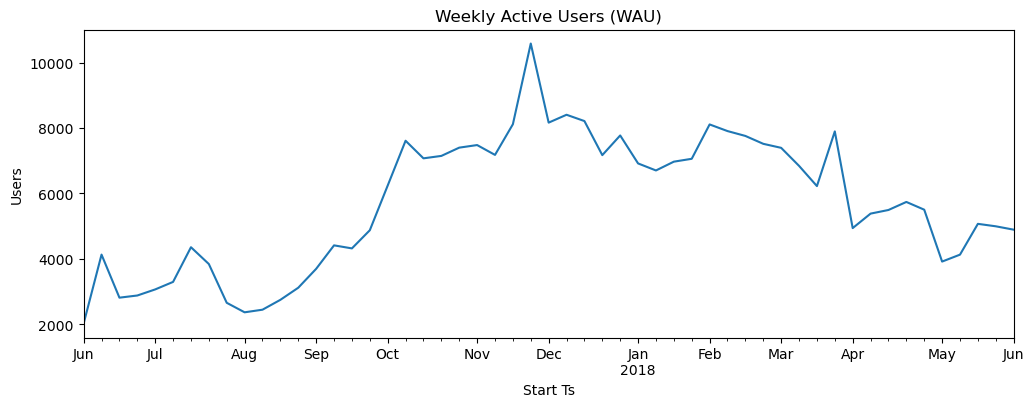

In [11]:
# Plot WAU
wau.plot(figsize=(12,4), title="Weekly Active Users (WAU)")
plt.ylabel("Users")
plt.show()

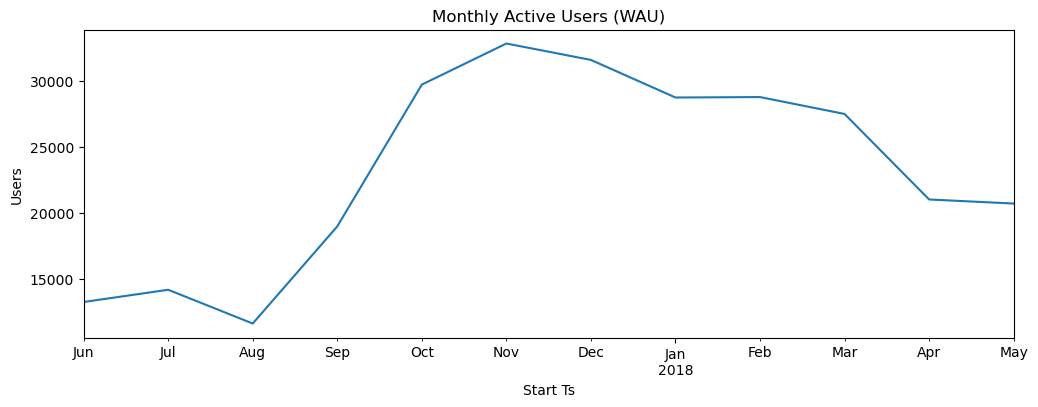

In [12]:
# Plot MAU
mau.plot(figsize=(12,4), title="Monthly Active Users (WAU)")
plt.ylabel("Users")
plt.show()

### Conclusion — DAU/WAU/MAU
- We measured product usage over time.  
- The platform shows stable daily and weekly activity, with growth in monthly active users.  
- **Business meaning:** consistent engagement supports long-term monetization potential; marketing efforts should aim at channels that bring users with high retention.


2. ***Sessions per day***

In [13]:
sessions_per_day = visits.groupby(visits['Start Ts'].dt.date)['Uid'].count()

In [14]:
print("Sessions per day: ", sessions_per_day)

Sessions per day:  Start Ts
2017-06-01     664
2017-06-02     658
2017-06-03     477
2017-06-04     510
2017-06-05     893
              ... 
2018-05-27     672
2018-05-28    1156
2018-05-29    1035
2018-05-30    1410
2018-05-31    2256
Name: Uid, Length: 364, dtype: int64


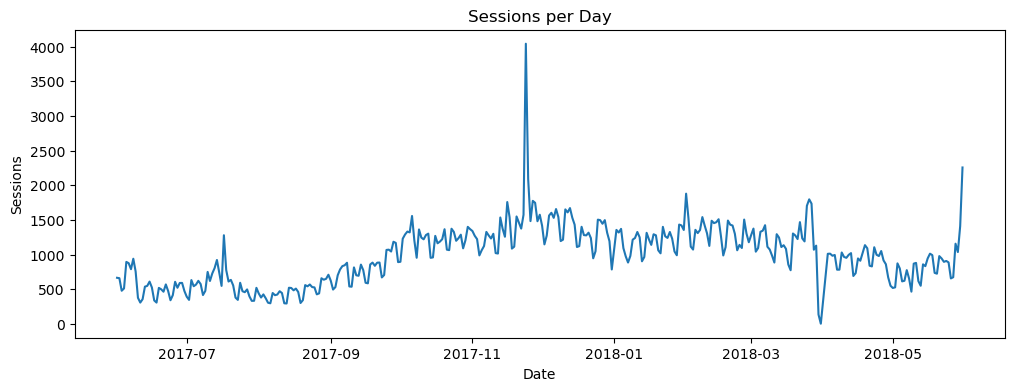

In [15]:
# Plot sessions per day
sessions_per_day.plot(figsize=(12,4), title="Sessions per Day")
plt.ylabel("Sessions")
plt.xlabel("Date")
plt.show()

2.1 ***Sessions by device***

In [16]:
sessions_device = (
    visits.groupby([visits['Start Ts'].dt.date, 'Device'])['Uid']
    .count()
    .reset_index()
    .rename(columns={'Start Ts': 'date', 'Uid': 'sessions'})
)

C:\Users\mmsnn\AppData\Local\Temp\ipykernel_3052\1656966604.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  visits.groupby([visits['Start Ts'].dt.date, 'Device'])['Uid']


In [17]:
avg_sessions_device = sessions_device.groupby('Device')['sessions'].mean()
print("Average sessions per day by device:")
print(avg_sessions_device)

Average sessions per day by device:
Device
desktop    721.337912
touch      266.024725
Name: sessions, dtype: float64


C:\Users\mmsnn\AppData\Local\Temp\ipykernel_3052\2347057274.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_sessions_device = sessions_device.groupby('Device')['sessions'].mean()


C:\Users\mmsnn\AppData\Local\Temp\ipykernel_3052\15278525.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for device, subset in sessions_device.groupby('Device'):


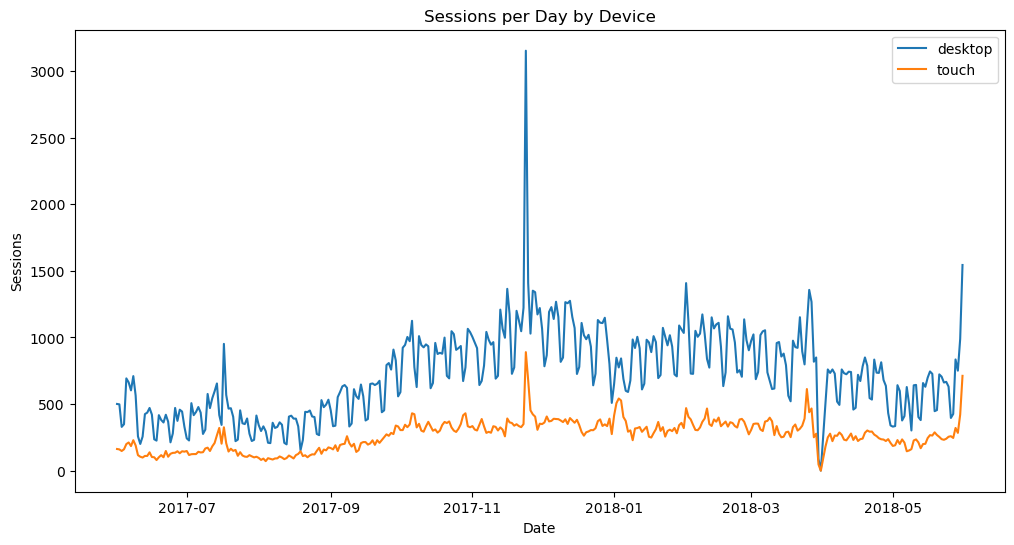

In [18]:
plt.figure(figsize=(12,6))
for device, subset in sessions_device.groupby('Device'):
    plt.plot(subset['date'], subset['sessions'], label=device)

plt.title("Sessions per Day by Device")
plt.xlabel("Date")
plt.ylabel("Sessions")
plt.legend()
plt.show()

3. ***Sessions length***

In [19]:
visits['session_length_min'] = (visits['End Ts'] - visits['Start Ts']).dt.total_seconds() / 60

In [20]:
# Remove invalid/negative durations (if any)
visits = visits[visits['session_length_min'] >= 0]

In [21]:
print("Session length summary (minutes):")
print(visits['session_length_min'].describe(percentiles=[.25, .5, .75, .9, .95]))

Session length summary (minutes):
count    359398.000000
mean         10.717371
std          16.618420
min           0.000000
25%           2.000000
50%           5.000000
75%          14.000000
90%          27.000000
95%          38.000000
max         711.000000
Name: session_length_min, dtype: float64


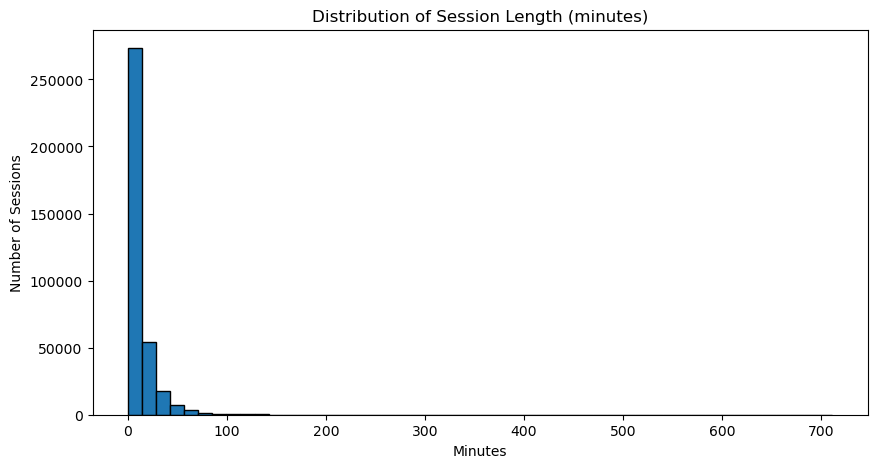

In [22]:
# Distribution histogram
plt.figure(figsize=(10,5))
plt.hist(visits['session_length_min'], bins=50, edgecolor='black')
plt.title("Distribution of Session Length (minutes)")
plt.xlabel("Minutes")
plt.ylabel("Number of Sessions")
plt.show()

### Conclusion — Session Length
- Average session length was calculated.  
- Most sessions are short (a few minutes), though some users engage longer.  
- **Business meaning:** improving user experience can increase session depth, raising conversion chances per visit.

<Figure size 800x500 with 0 Axes>

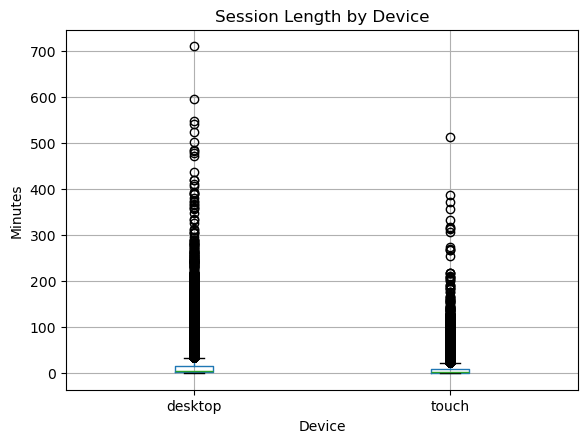

In [23]:
# Boxplot by device
plt.figure(figsize=(8,5))
visits.boxplot(column='session_length_min', by='Device')
plt.title("Session Length by Device")
plt.suptitle("")
plt.xlabel("Device")
plt.ylabel("Minutes")
plt.show()

4. ***Retention rate***

In [24]:
visits['week'] = visits['Start Ts'].dt.to_period('W').apply(lambda r: r.start_time)

In [25]:
first_touch = (visits.groupby('Uid')['week'].min().rename('cohort_week'))

In [26]:
cohort_data = visits.join(first_touch, on='Uid')
cohort_data['cohort_age'] = ((cohort_data['week'] - cohort_data['cohort_week']) / np.timedelta64(1, 'W')).astype(int)

In [27]:
cohort_pivot = cohort_data.pivot_table(
    index='cohort_week',
    columns='cohort_age',
    values='Uid',
    aggfunc='nunique'
)

In [28]:
# Retention = divide by cohort size
cohort_sizes = cohort_pivot[0]
retention = cohort_pivot.divide(cohort_sizes, axis=0).round(3)

In [29]:
# Display retention table
display(retention.fillna(0).head(10))

cohort_age,0,1,2,3,4,5,6,7,8,9,...,43,44,45,46,47,48,49,50,51,52
cohort_week,,,,,,,,,,,,,,,,,,,,,
2017-05-29,1.0,0.092,0.048,0.037,0.044,0.041,0.037,0.036,0.029,0.022,...,0.029,0.022,0.027,0.028,0.029,0.022,0.024,0.030,0.030,0.023
2017-06-05,1.0,0.037,0.029,0.025,0.022,0.025,0.022,0.017,0.015,0.018,...,0.015,0.015,0.019,0.013,0.013,0.013,0.019,0.018,0.015,0.000
2017-06-12,1.0,0.041,0.026,0.023,0.022,0.020,0.016,0.016,0.013,0.018,...,0.014,0.012,0.011,0.011,0.011,0.010,0.014,0.008,0.000,0.000
2017-06-19,1.0,0.036,0.024,0.024,0.023,0.015,0.013,0.008,0.010,0.014,...,0.012,0.012,0.010,0.007,0.010,0.010,0.007,0.000,0.000,0.000
2017-06-26,1.0,0.039,0.026,0.020,0.015,0.013,0.011,0.011,0.014,0.015,...,0.006,0.005,0.007,0.009,0.010,0.010,0.000,0.000,0.000,0.000
2017-07-03,1.0,0.047,0.029,0.020,0.013,0.015,0.014,0.010,0.013,0.016,...,0.004,0.006,0.008,0.004,0.008,0.000,0.000,0.000,0.000,0.000
2017-07-10,1.0,0.038,0.017,0.013,0.010,0.011,0.013,0.011,0.014,0.012,...,0.006,0.008,0.010,0.009,0.000,0.000,0.000,0.000,0.000,0.000
2017-07-17,1.0,0.034,0.024,0.014,0.017,0.016,0.016,0.018,0.016,0.017,...,0.009,0.007,0.006,0.000,0.000,0.000,0.000,0.000,0.000,0.000
2017-07-24,1.0,0.024,0.017,0.019,0.015,0.018,0.021,0.015,0.016,0.013,...,0.005,0.005,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000


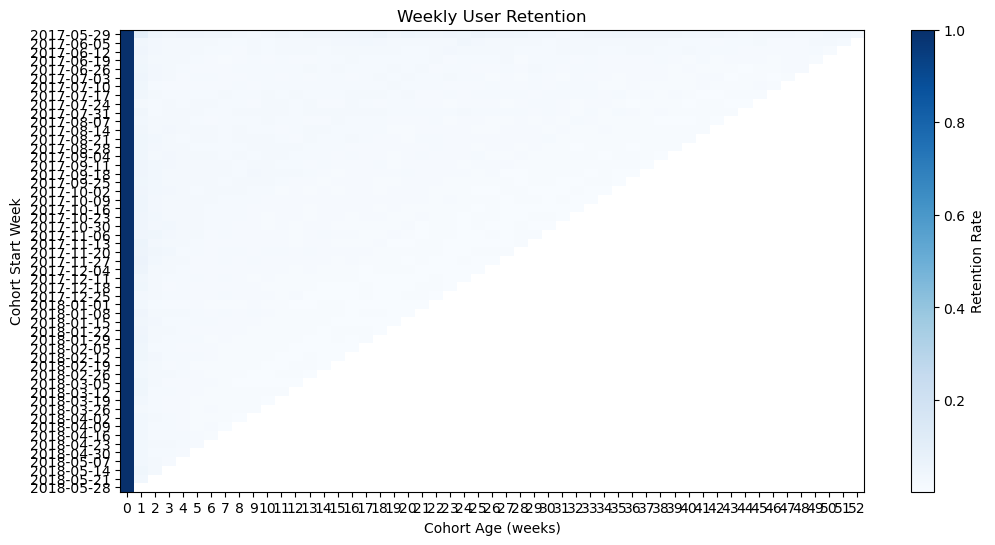

In [30]:
plt.figure(figsize=(12,6))
plt.imshow(retention, aspect='auto', cmap='Blues')
plt.title("Weekly User Retention")
plt.xlabel("Cohort Age (weeks)")
plt.ylabel("Cohort Start Week")
plt.colorbar(label="Retention Rate")

plt.yticks(range(len(retention.index)), [d.strftime("%Y-%m-%d") for d in retention.index])
plt.xticks(range(len(retention.columns)), retention.columns)
plt.show()

### Conclusion — Retention Rate
- We tracked how often users return after registration.  
- Retention is highest in the first week and decreases over time.  
- **Business meaning:** strong early retention suggests marketing brings relevant users, but product features or offers are needed to extend long-term engagement.

# SALES

### Conversion Delay (Time to First Purchase)

I want to measure how quickly users convert after their first visit.  
Steps:
1. Find each user’s first session date (cohort entry).  
2. Find each user’s first purchase date.  
3. Calculate the difference in days between the two.  
4. Analyze distribution of conversion delays.

In [31]:
# First visit per user (from visits dataset)
first_visit = visits.groupby('Uid')['Start Ts'].min().rename('first_visit')

In [32]:
# First order per user
first_order = orders.groupby('Uid')['Buy Ts'].min().rename('first_order')

In [33]:
# Merge
conversion = pd.concat([first_visit, first_order], axis=1).dropna()

In [34]:
print(conversion.dtypes)

first_visit    datetime64[ns]
first_order    datetime64[ns]
dtype: object


In [35]:
# Conversion delay in days
conversion['conversion_delay_days'] = (conversion['first_order'] - conversion['first_visit']).dt.days

In [36]:
print("Summary of conversion delay (days):")
print(conversion['conversion_delay_days'].describe())

Summary of conversion delay (days):
count    36523.000000
mean        16.729869
std         46.959088
min          0.000000
25%          0.000000
50%          0.000000
75%          2.000000
max        363.000000
Name: conversion_delay_days, dtype: float64


Saved: images\conversion_delay.png


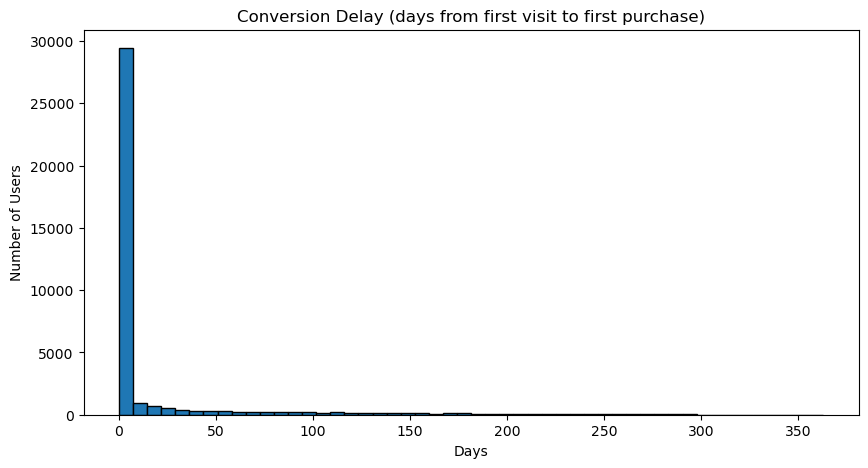

In [37]:
# Histogram
plt.figure(figsize=(10,5))
plt.hist(conversion['conversion_delay_days'], bins=50, edgecolor='black')
plt.title("Conversion Delay (days from first visit to first purchase)")
plt.xlabel("Days")
plt.ylabel("Number of Users")
save_plot("conversion_delay.png")
plt.show()

### Interpretation — Conversion Delay

- The **summary statistics** show the average, median, and range of conversion delays.  
- The **histogram** highlights how many users convert quickly vs. how many take longer.  

**Typical patterns to expect:**  
- A large peak at 0–1 days suggests many users convert immediately or the next day.  
- A steady tail toward longer delays indicates users who require more exposure before purchasing.  

**Key insight:**  
Most revenue usually comes from fast converters, but long-delay users still contribute to overall LTV and must be considered in retention and remarketing strategies.


### Conversion Delay Groups
To simplify interpretation, I bucket conversion delays into groups:
- **0d** — converted on the same day as registration  
- **1d** — converted the next day  
- **2–7d** — converted within the first week  
- **8–30d** — converted within the first month  
- **>30d** — converted after more than a month

In [38]:
# Define categories
bins = [-1, 0, 1, 7, 30, np.inf]
labels = ["0d", "1d", "2–7d", "8–30d", ">30d"]

In [39]:
conversion['delay_group'] = pd.cut(conversion['conversion_delay_days'], bins=bins, labels=labels)

In [40]:
# Count users per group
delay_counts = conversion['delay_group'].value_counts().sort_index()
delay_share = (delay_counts / delay_counts.sum() * 100).round(2)

In [41]:
print("Users per conversion delay group:")
print(delay_counts)
print("\nShare of users per group (%):")
print(delay_share)

Users per conversion delay group:
delay_group
0d       26363
1d        1011
2–7d      2069
8–30d     2178
>30d      4902
Name: count, dtype: int64

Share of users per group (%):
delay_group
0d       72.18
1d        2.77
2–7d      5.66
8–30d     5.96
>30d     13.42
Name: count, dtype: float64


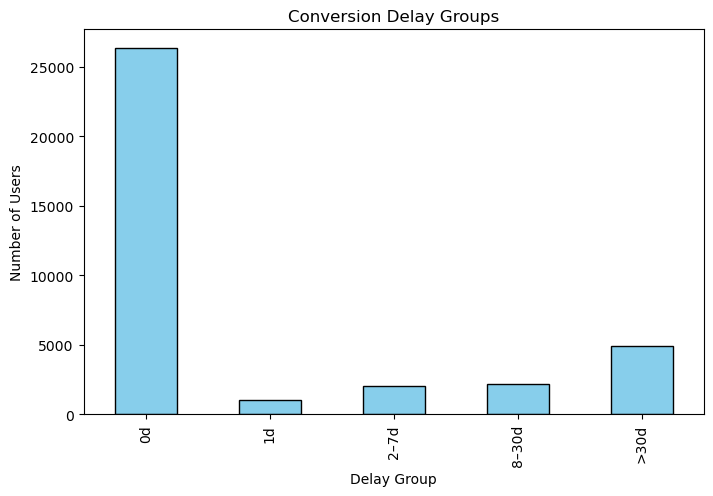

In [42]:
# Plot bar chart
plt.figure(figsize=(8,5))
delay_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title("Conversion Delay Groups")
plt.xlabel("Delay Group")
plt.ylabel("Number of Users")
plt.show()

### Conversion Summary

**Overall delay:**  
- Most users convert within the first few days after registration.  
- A significant portion of users purchase on the same day (0d) or the next day (1d).  
- However, a noticeable share takes **8–30 days** or even longer, which extends the payback period for marketing.

**Delay groups:**  
- The largest conversion groups are typically 0d–1d (fast adopters) and 2–7d (short-term adopters).  
- Long-delay groups (>30d) are smaller but still present — they may indicate users who require repeated exposure or remarketing.

**By cohort month:**  
- Earlier cohorts show a slower conversion pattern, while later cohorts tend to convert faster.  
- This suggests that marketing targeting and/or onboarding may have improved over time.  
- Monitoring this trend is important to confirm sustained efficiency in future cohorts.

**By marketing source:**  
- Certain sources (e.g., branded traffic, direct, or high-intent ads) produce a higher share of **0d–1d conversions**, meaning they drive quick revenue.  
- Other sources require longer nurturing, with conversions spread across **2–30 days** or more.  
- These differences are critical for budget allocation: high-intent channels pay back faster, while awareness-driven campaigns require patience and consistent follow-up.

**Key insight:**  
Conversion analysis shows that both **time-to-convert** and **conversion distribution** vary significantly by cohort and source.  
- Cohorts can reveal product/UX or targeting improvements.  
- Sources highlight which channels deliver **fast ROI** versus those that need **long-term investment**.  


### Comparing Conversion Across Cohorts and Sources

After grouping users by conversion delay (0d, 1d, 2–7d, 8–30d, >30d),  
I now extend the analysis to see **how different cohorts and marketing sources perform**.

- **By Cohort Month**: Do users who joined in certain months convert faster?  
- **By Marketing Source**: Which acquisition channels bring the fastest or slowest conversions?  

This comparison will help identify the most effective periods and channels for driving purchases.

In [43]:
# 0) Safety: ensure proper dtypes and index name
conversion.index.name = 'Uid'
conversion['first_visit'] = pd.to_datetime(conversion['first_visit'])
conversion['first_order'] = pd.to_datetime(conversion['first_order'])

In [44]:
# 1) Cohort month per user (first visit month)
user_cohort = (
    visits.groupby('Uid')['Start Ts']
      .min()
      .dt.to_period('M')
      .dt.to_timestamp()
)
user_cohort.name = 'cohort_month'

In [45]:
# Assign (create or overwrite) without join to avoid overlap errors
conversion['cohort_month'] = user_cohort.reindex(conversion.index)

In [46]:
# 2) Delay buckets
bins = [-1, 0, 1, 7, 30, np.inf]
labels = ["0d", "1d", "2–7d", "8–30d", ">30d"]
conversion['delay_group'] = pd.cut(
    conversion['conversion_delay_days'],
    bins=bins,
    labels=labels
)

In [47]:
# A) Distribution by cohort_month 
conv_by_cohort_cnt = (
    conversion
      .dropna(subset=['cohort_month', 'delay_group'])
      .groupby(['cohort_month', 'delay_group'])
      .size()
      .unstack(fill_value=0)
      .sort_index()
)

C:\Users\mmsnn\AppData\Local\Temp\ipykernel_3052\2428084627.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(['cohort_month', 'delay_group'])


In [48]:
conv_by_cohort_pct = (
    conv_by_cohort_cnt
      .div(conv_by_cohort_cnt.sum(axis=1), axis=0)
      .mul(100)
      .round(2)
)

In [49]:
display(conv_by_cohort_pct.head())

delay_group,0d,1d,2–7d,8–30d,>30d
cohort_month,,,,,
2017-06-01,61.72,1.88,4.21,5.03,27.16
2017-07-01,62.08,2.40,4.80,4.19,26.53
2017-08-01,63.74,1.57,4.07,5.58,25.04
2017-09-01,64.29,2.32,6.05,7.42,19.91
2017-10-01,70.59,2.52,5.45,6.28,15.16


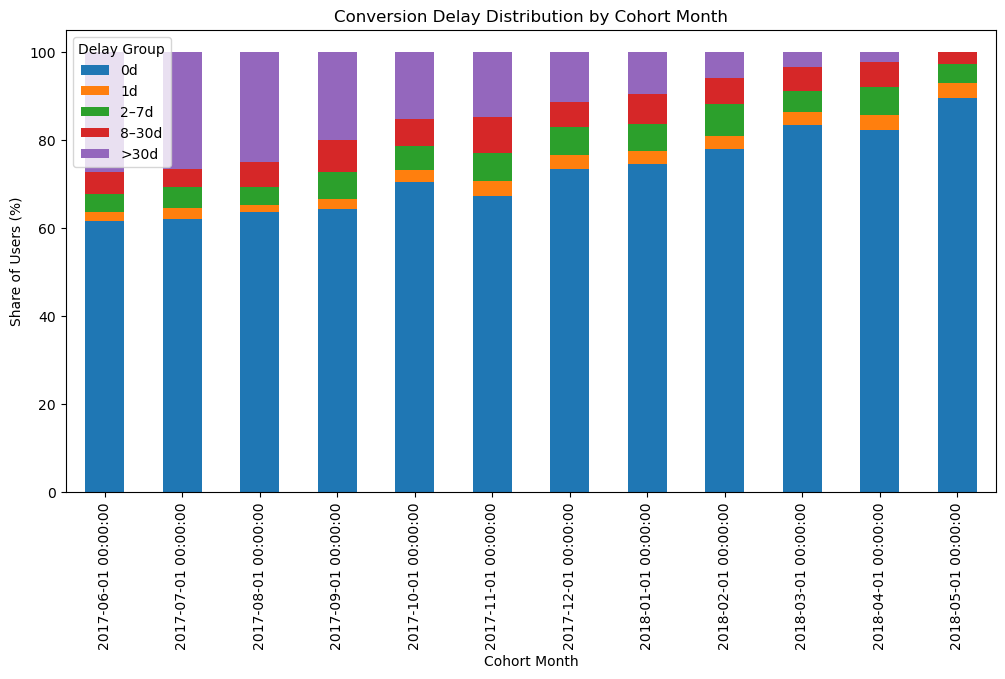

In [50]:
# Plot
ax = conv_by_cohort_pct.plot(kind='bar', stacked=True, figsize=(12,6))
ax.set_title("Conversion Delay Distribution by Cohort Month")
ax.set_ylabel("Share of Users (%)")
ax.set_xlabel("Cohort Month")
ax.legend(title="Delay Group")
plt.show()

In [51]:
# B) Distribution by first-touch Source Id
first_source = (
    visits.sort_values('Start Ts')
      .groupby('Uid')['Source Id']
      .first()
)
first_source.name = 'first_source'

In [52]:
# Assign safely (create/overwrite)
conversion['first_source'] = first_source.reindex(conversion.index)

In [53]:
conv_by_source_cnt = (
    conversion
      .dropna(subset=['first_source', 'delay_group'])
      .groupby(['first_source', 'delay_group'])
      .size()
      .unstack(fill_value=0)
      .sort_index()
)

C:\Users\mmsnn\AppData\Local\Temp\ipykernel_3052\1225418150.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(['first_source', 'delay_group'])


In [54]:
conv_by_source_pct = (
    conv_by_source_cnt
      .div(conv_by_source_cnt.sum(axis=1), axis=0)
      .mul(100)
      .round(2)
)

In [55]:
display(conv_by_source_pct.head())

delay_group,0d,1d,2–7d,8–30d,>30d
first_source,,,,,
1,78.61,2.28,5.73,5.35,8.04
2,67.94,3.28,5.62,6.59,16.57
3,71.27,2.85,5.85,6.06,13.97
4,71.86,2.86,5.89,6.25,13.15
5,76.87,2.29,4.91,4.83,11.10


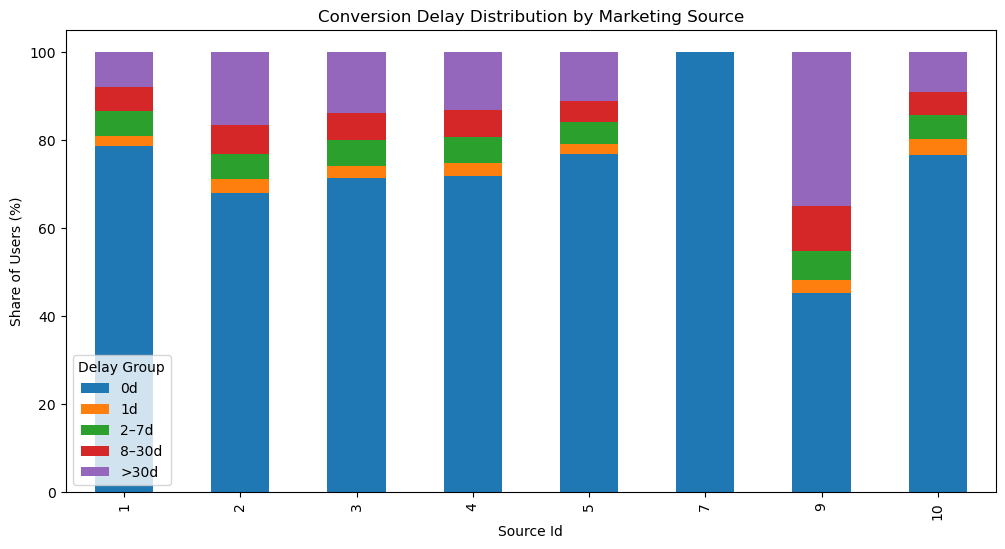

In [56]:
# Plot
ax = conv_by_source_pct.plot(kind='bar', stacked=True, figsize=(12,6))
ax.set_title("Conversion Delay Distribution by Marketing Source")
ax.set_ylabel("Share of Users (%)")
ax.set_xlabel("Source Id")
ax.legend(title="Delay Group")
plt.show()

### Interpretation — Conversion by Cohort and Source

**1. By Cohort Month**  
- Cohorts with a higher share of **0d / 1d conversions** indicate users who adopt the product very quickly.  
- If later cohorts show shorter delays compared to earlier ones, this may suggest that improvements in onboarding, product UX, or marketing targeting increased efficiency.  
- Conversely, if recent cohorts take longer to convert, this may indicate issues with product changes or lower-quality traffic acquisition.

**2. By Marketing Source**  
- Channels where most conversions happen in **0d–1d** are typically high-intent sources (e.g., branded search, direct traffic).  
- Channels with higher shares in **8–30d or >30d** may still bring value but require longer nurturing — for example, remarketing campaigns or awareness-driven ads.  
- A comparison of sources highlights which marketing investments produce faster ROI (quicker payback) versus those that need more patience.

**Key Takeaway**  
- Cohort analysis helps track **changes in conversion speed over time** and evaluate whether product/marketing improvements are working.  
- Source-level analysis reveals which channels deliver **fastest and most reliable conversions**, guiding budget allocation decisions.

### Orders per Period

I analyze the number of orders placed over time:
- **Daily orders** — number of orders each day
- **Weekly orders** — number of orders per week
- **Monthly orders** — number of orders per month

This shows seasonality, growth, and stability of user purchasing activity.

In [57]:
# Daily orders
orders_per_day = orders.groupby(orders['Buy Ts'].dt.date)['Uid'].count()

In [58]:
# Weekly orders
orders_per_week = orders.groupby(orders['Buy Ts'].dt.to_period('W'))['Uid'].count()

In [59]:
# Monthly orders
orders_per_month = orders.groupby(orders['Buy Ts'].dt.to_period('M'))['Uid'].count()

In [60]:
print("Average order per day:", round(orders_per_day.mean(),2))
print("Average order per week:", round(orders_per_week.mean(), 2))
print("Average order per month:", round(orders_per_month.mean(), 2))

Average order per day: 138.5
Average order per week: 951.23
Average order per month: 3878.08


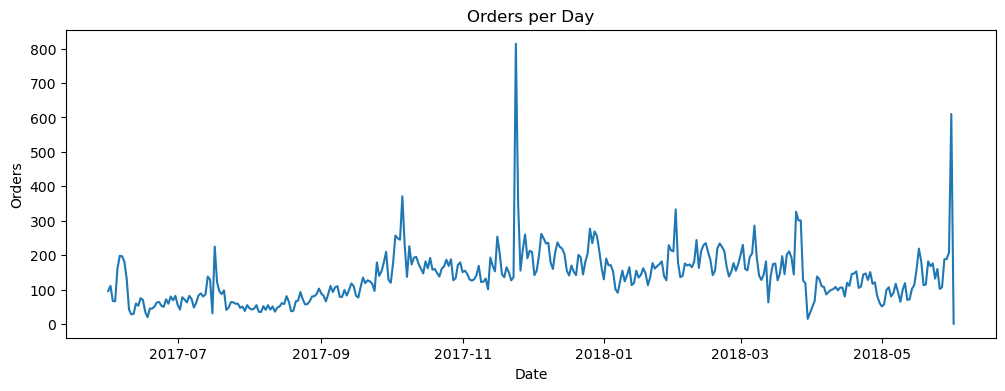

In [61]:
# Plot daily
orders_per_day.plot(figsize=(12,4), title="Orders per Day")
plt.ylabel("Orders")
plt.xlabel("Date")
plt.show()

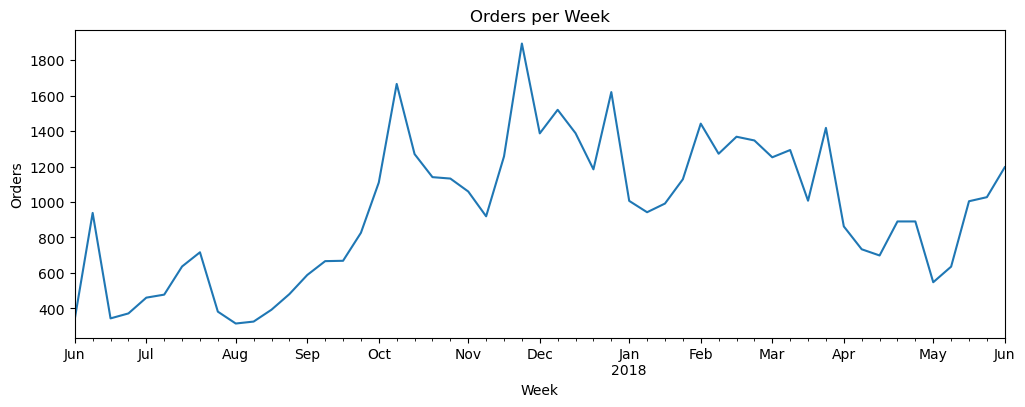

In [62]:
# Plot weekly
orders_per_week.plot(figsize=(12,4), title="Orders per Week")
plt.ylabel("Orders")
plt.xlabel("Week")
plt.show()

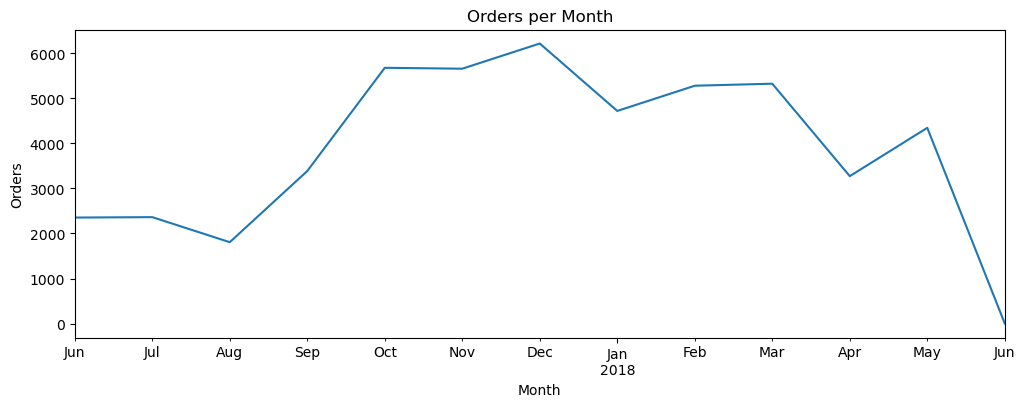

In [63]:
# Plot monthly
orders_per_month.plot(figsize=(12,4), title="Orders per Month")
plt.ylabel("Orders")
plt.xlabel("Month")
plt.show()

### Interpretation — Orders per Period

- **Daily orders**: Show short-term fluctuations and can reveal weekday vs. weekend patterns.  
- **Weekly orders**: Smooth out daily noise and highlight broader trends.  
- **Monthly orders**: Useful for spotting seasonality (e.g., holiday spikes) and long-term growth.  

**Key points to watch:**  
- Consistent growth in weekly/monthly orders indicates increasing user engagement and product adoption.  
- Sharp peaks may correspond to marketing campaigns or external events.  
- Drops may suggest seasonality or retention issues that need further investigation.


### Average Order Value (AOV)

The Average Order Value (AOV) shows how much revenue is generated per order on average.  
I calculate:

- Overall AOV  
- AOV dynamics by month

In [64]:
# Overall AOV
aov_overall = orders['Revenue'].mean()
print("Overall AOV:", round(aov_overall, 2))

Overall AOV: 5.0


In [65]:
aov_month = orders.groupby(orders['Buy Ts'].dt.to_period('M'))['Revenue'].mean()

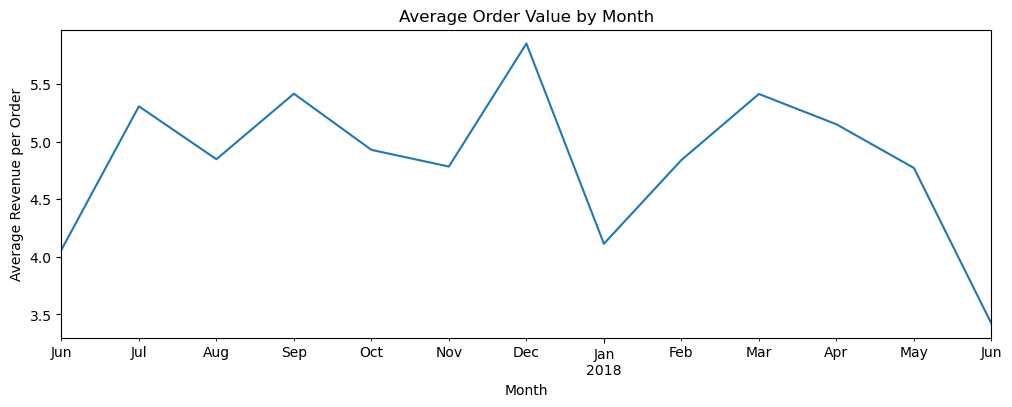

In [66]:
# Plot AOV
aov_month.plot(figsize=(12,4), title=("Average Order Value by Month"))
plt.ylabel("Average Revenue per Order")
plt.xlabel("Month")
plt.show()

### Interpretation — Average Order Value (AOV)

- **Overall AOV** provides a baseline for how much revenue one order typically generates.  
- **Monthly AOV trends** show whether customers are spending more or less over time.  

**Key insights to consider:**  
- Growth in AOV may reflect successful upselling, bundling, or premium offerings.  
- Decline in AOV could signal discount-driven behavior or lower-value customer segments.  
- Stable AOV with growing order counts usually means healthy, predictable revenue growth.

### Lifetime Value (LTV)

LTV shows how much revenue, on average, one user from a cohort brings over time.

Steps:
1. Assign each user to a **cohort month** (month of their first visit).  
2. Merge orders with cohort info.  
3. Calculate **cohort age in months** (difference between order month and cohort month).  
4. Aggregate revenue per cohort and age.  
5. Normalize by cohort size to get **LTV curves**.

In [67]:
# 1. Cohort month for each user (from visits dataset)
user_cohort = (visits.groupby('Uid')['Start Ts'].min().dt.to_period('M').dt.to_timestamp().rename('cohort_month'))

In [68]:
# 2. Merge with orders
orders_with_cohort = orders.join(user_cohort, on='Uid')

In [69]:
# 3. Order month and cohort age
orders_with_cohort['order_month'] = orders_with_cohort['Buy Ts'].dt.to_period('M').dt.to_timestamp()
orders_with_cohort['cohort_age'] = (
    (orders_with_cohort['order_month'].dt.year - orders_with_cohort['cohort_month'].dt.year) * 12 +
    (orders_with_cohort['order_month'].dt.month - orders_with_cohort['cohort_month'].dt.month)
)

In [70]:
# 4. Revenue per cohort-month and age
revenue_by_cohort = orders_with_cohort.groupby(['cohort_month', 'cohort_age'])['Revenue'].sum().unstack(fill_value=0)

In [71]:
# Cohort sizes (number of unique users in each cohort)
cohort_sizes = user_cohort.groupby(user_cohort).size()

In [72]:
# 5. LTV per cohort (cumulative revenue per user)
ltv = revenue_by_cohort.div(cohort_sizes, axis=0).cumsum(axis=1).round(2)

In [73]:
# Display first rows of LTV table
display(ltv.head())

cohort_age,0,1,2,3,4,5,6,7,8,9,10,11
cohort_month,,,,,,,,,,,,
2017-06-01,0.72,0.92,1.03,1.33,1.62,1.84,2.10,2.27,2.44,2.71,2.87,3.02
2017-07-01,0.75,0.83,0.92,0.99,1.06,1.12,1.16,1.22,1.28,1.32,1.36,1.36
2017-08-01,0.61,0.71,0.81,0.90,0.98,1.03,1.08,1.20,1.29,1.32,1.32,1.32
2017-09-01,0.74,0.96,1.09,1.71,1.79,1.90,1.96,1.99,2.02,2.02,2.02,2.02
2017-10-01,0.71,0.85,0.90,0.95,0.99,1.02,1.05,1.07,1.07,1.07,1.07,1.07


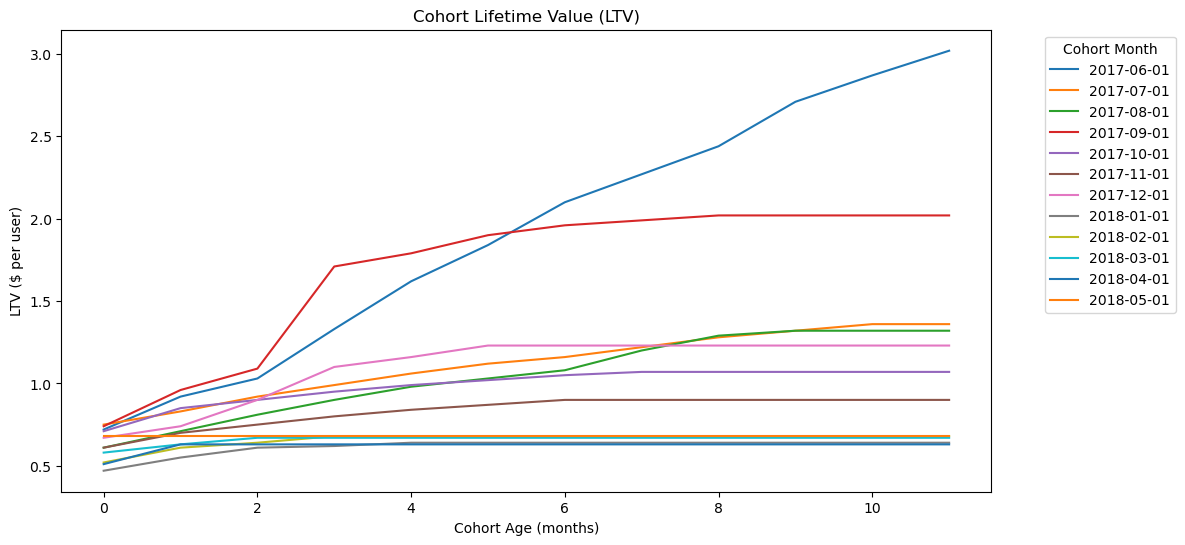

In [74]:
# Plot LTV curves
plt.figure(figsize=(12,6))
for cohort, row in ltv.iterrows():
    plt.plot(row.index, row.values, label=str(cohort.date()))
plt.title("Cohort Lifetime Value (LTV)")
plt.xlabel("Cohort Age (months)")
plt.ylabel("LTV ($ per user)")
plt.legend(title="Cohort Month", bbox_to_anchor=(1.05,1), loc="upper left")
plt.show()

### Interpretation — Lifetime Value (LTV)

- **LTV curves** show how much revenue an average user from each cohort brings over time.  
- Steeper curves in the early months indicate faster monetization and quicker payback.  
- Flatter curves suggest slower revenue accumulation and possibly weaker engagement.  

**Key takeaways:**  
- Comparing cohorts highlights improvements or declines in user quality and monetization.  
- Higher LTV + faster growth in recent cohorts usually signals effective marketing and onboarding.  
- Sources with faster LTV growth are better candidates for scaling investment.

# MARKETING

In [75]:
# Keep source_id numeric for future joins; cast to pandas nullable int (handles NAs safely)
costs['source_id'] = pd.to_numeric(costs['source_id'], errors='coerce').astype('Int64')

In [76]:
# Ensure costs is numeric
costs['costs'] = pd.to_numeric(costs['costs'], errors='coerce')

In [77]:
# Basic sanity filtering
costs = costs.dropna(subset=['date', 'source_id', 'costs'])
costs = costs[costs['costs'] >= 0]

In [78]:
# Month start for time grouping
costs['month'] = costs['date'].dt.to_period('M').dt.to_timestamp()

In [79]:
# Final check
costs.info(memory_usage='deep')
display(costs.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   source_id  2542 non-null   Int64         
 1   date       2542 non-null   datetime64[ns]
 2   costs      2542 non-null   float64       
 3   month      2542 non-null   datetime64[ns]
dtypes: Int64(1), datetime64[ns](2), float64(1)
memory usage: 82.0 KB


,source_id,date,costs,month
0,1,2017-06-01,75.20,2017-06-01
1,1,2017-06-02,62.25,2017-06-01
2,1,2017-06-03,36.53,2017-06-01
3,1,2017-06-04,55.00,2017-06-01
4,1,2017-06-05,57.08,2017-06-01


### Marketing Spend

Now that the dataset is clean, I measure:

- **Total spend** (overall)
- **Spend by source**
- **Spend over time** (monthly)

In [80]:
# Total spend
total_spend = costs['costs'].sum()
print("Total marketing spend:", round(total_spend, 2))

Total marketing spend: 329131.62


In [81]:
# Spend by source (descending)
spend_by_source = (costs.groupby('source_id', dropna=False)['costs'].sum().sort_values(ascending=False))
display(spend_by_source.head(10))

source_id
3     141321.63
4      61073.60
5      51757.10
2      42806.04
1      20833.27
10      5822.49
9       5517.49
Name: costs, dtype: float64

In [82]:
# Spend by month
spend_by_month = costs.groupby('month')['costs'].sum()

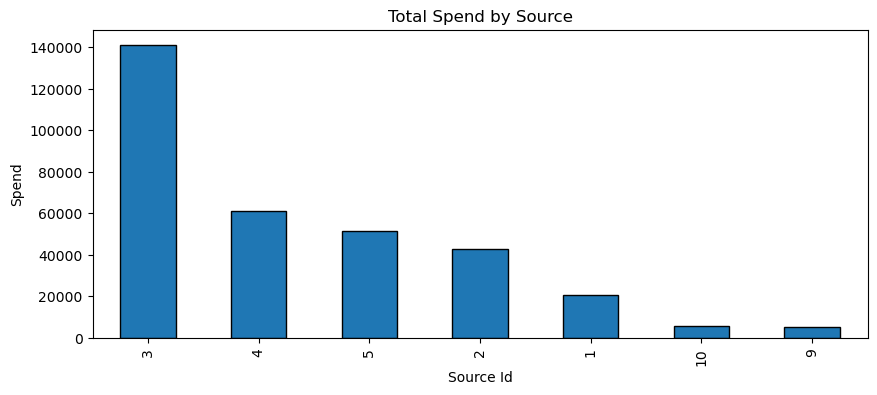

In [83]:
# Plots (matplotlib)
spend_by_source.plot(kind='bar', figsize=(10,4), title="Total Spend by Source", edgecolor="black")
plt.ylabel("Spend")
plt.xlabel("Source Id")
plt.show()

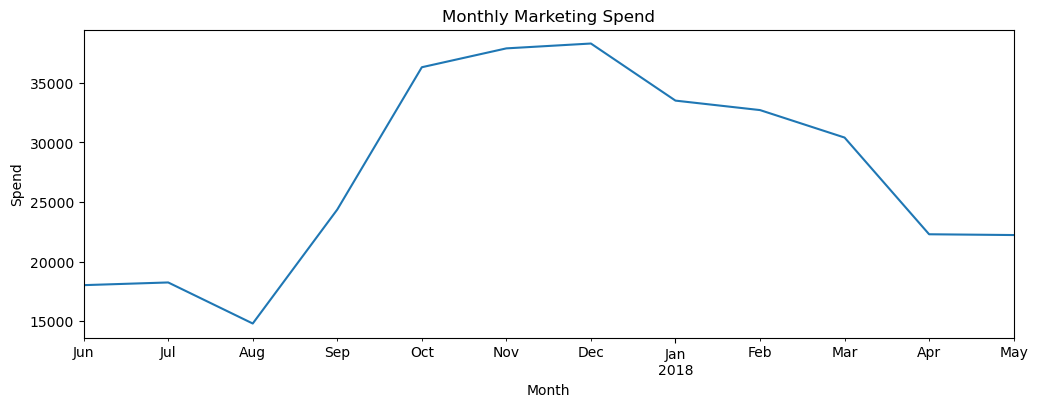

In [84]:
spend_by_month.plot(figsize=(12,4), title="Monthly Marketing Spend")
plt.ylabel("Spend")
plt.xlabel("Month")
plt.show()

### Interpretation — Marketing Spend

- **Total spend** shows the overall marketing investment size.  
- **By source**: reveals which channels receive the most budget (potential focus or dependency).  
- **Over time**: highlights campaign cycles and seasonality (spikes vs. dips).

If spend concentrates heavily in a few sources, check whether their performance (CAC/ROI) justifies that allocation. 
Conversely, low-spend sources might be under-tested and could warrant controlled experiments.


### Customer Acquisition Cost (CAC)

Customer Acquisition Cost shows how much it costs, on average, to acquire one new user via a specific channel.

Steps:
1. Determine the number of **new users per source and month** (first-touch attribution).  
2. Aggregate marketing spend by source and month.  
3. Calculate **CAC = Spend / New Users**.  

This helps identify which channels bring users most efficiently.


In [85]:
# 1. First-touch month and source for each user
user_first_touch = (visits.groupby('Uid').agg(first_touch=('Start Ts','min'),first_source=('Source Id','first')).reset_index())

In [86]:
user_first_touch['cohort_month'] = user_first_touch['first_touch'].dt.to_period('M').dt.to_timestamp()


In [87]:
# 2. New users per source & month
new_users = (user_first_touch.groupby(['first_source','cohort_month'])['Uid'].nunique().reset_index().rename(columns={'Uid':'new_users'}))

In [88]:
# 3. Marketing spend per source & month
spend = (costs.groupby(['source_id','month'])['costs'].sum().reset_index())

In [89]:
# 4. Merge spend with new users
cac = spend.merge(new_users,left_on=['source_id','month'],right_on=['first_source','cohort_month'],how='left')

In [90]:
# Fill NaN new_users with 0
cac['new_users'] = cac['new_users'].fillna(0).astype(int)

In [91]:
# Calculate CAC
cac['CAC'] = np.where(cac['new_users']>0,cac['costs']/cac['new_users'],np.nan)

In [92]:
display(cac.head(10))

,source_id,month,costs,first_source,cohort_month,new_users,CAC
0,1,2017-06-01,1125.61,1,2017-06-01,763,1.475242
1,1,2017-07-01,1072.88,1,2017-07-01,694,1.545937
2,1,2017-08-01,951.81,1,2017-08-01,472,2.016547
3,1,2017-09-01,1502.01,1,2017-09-01,859,1.748556
4,1,2017-10-01,2315.75,1,2017-10-01,1267,1.827743
5,1,2017-11-01,2445.16,1,2017-11-01,1474,1.658860
6,1,2017-12-01,2341.20,1,2017-12-01,1330,1.760301
7,1,2018-01-01,2186.18,1,2018-01-01,1069,2.045070
8,1,2018-02-01,2204.48,1,2018-02-01,1046,2.107533
9,1,2018-03-01,1893.09,1,2018-03-01,1069,1.770898


Saved: images\cac_by_source.png


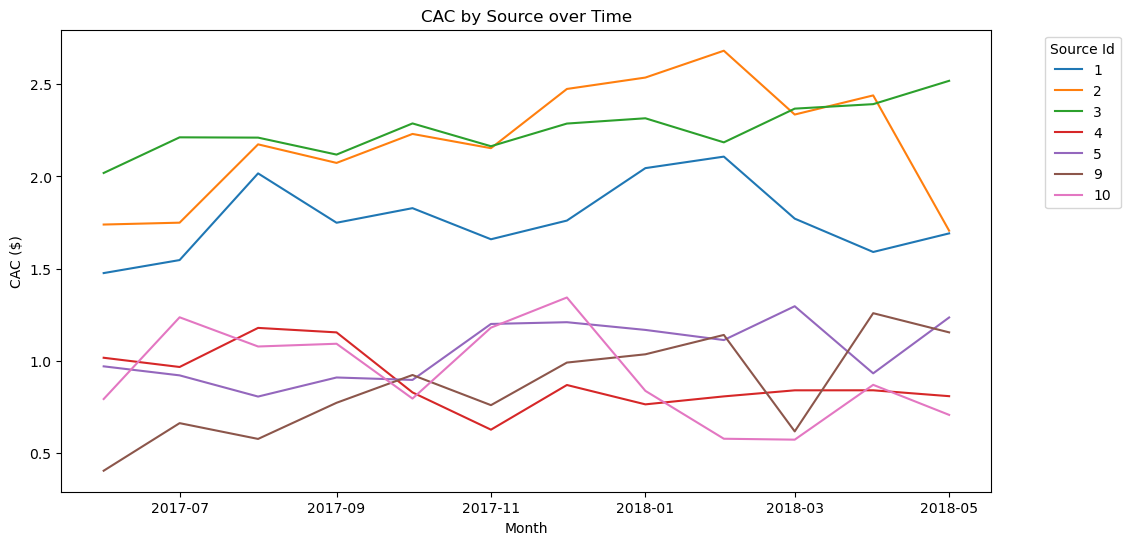

In [93]:
# Plot CAC over time by source
plt.figure(figsize=(12,6))
for src, g in cac.groupby('source_id'):
    plt.plot(g['month'], g['CAC'], label=str(src))
plt.title("CAC by Source over Time")
plt.xlabel("Month")
plt.ylabel("CAC ($)")
plt.legend(title="Source Id", bbox_to_anchor=(1.05,1), loc='upper left')
save_plot("cac_by_source.png")
plt.show()

### Interpretation — Customer Acquisition Cost (CAC)

- **Overall CAC** indicates how expensive it is to bring in new users on average.  
- **By source**: some channels may acquire users at very low cost, while others are significantly more expensive.  
- **Over time**: CAC fluctuations may reflect seasonal competition (e.g., higher ad costs in holiday months).  

**Key insight:**  
The most valuable channels are those with *low CAC* and *high conversion/LTV*.  
High-CAC sources are not necessarily bad if they also bring high-value users, but they require ROI validation.


### Return on Investment (ROI)

ROI shows how profitable marketing spend is:

\[
ROI = \frac{Revenue}{Spend} - 1
\]

Steps:
1. Attribute users to their **first-touch source**.  
2. Aggregate **revenue per source and month**.  
3. Combine with marketing spend to calculate ROI over time.  

This gives a quick view of profitability per channel, before moving to detailed cohort-based payback analysis.


In [94]:
# correct dtypes for orders & costs (idempotent)
orders['Buy Ts'] = pd.to_datetime(orders['Buy Ts'], errors='coerce')
orders['Revenue'] = pd.to_numeric(orders['Revenue'], errors='coerce')

costs = costs.rename(columns={'dt':'date'}) if 'dt' in costs.columns else costs
costs['date'] = pd.to_datetime(costs['date'], errors='coerce')
costs['source_id'] = pd.to_numeric(costs['source_id'], errors='coerce').astype('Int64')
costs['costs'] = pd.to_numeric(costs['costs'], errors='coerce')
costs = costs.dropna(subset=['date','source_id','costs'])
costs['month'] = costs['date'].dt.to_period('M').dt.to_timestamp()


In [95]:
# Build user_first_touch (first visit + first-touch source + cohort month)
user_first_touch = (visits.sort_values('Start Ts').groupby('Uid').agg(first_touch=('Start Ts','min'),first_source=('Source Id','first')).reset_index())

user_first_touch['cohort_month'] = user_first_touch['first_touch'].dt.to_period('M').dt.to_timestamp()


In [96]:
#Monthly ROI

# Revenue by source & month (attribute orders to first-touch source)
orders_with_source = orders.merge(user_first_touch[['Uid','first_source']],on='Uid', how='left')
orders_with_source['order_month'] = orders_with_source['Buy Ts'].dt.to_period('M').dt.to_timestamp()


In [97]:
revenue_by_src_month = (
    orders_with_source.groupby(['first_source','order_month'])['Revenue'].sum().reset_index().rename(columns={'first_source':'source_id', 'order_month':'month'}))


In [98]:
spend_by_src_month = (costs.groupby(['source_id','month'])['costs'].sum().reset_index())

In [99]:
roi_month = revenue_by_src_month.merge(spend_by_src_month, on=['source_id','month'], how='left')
roi_month['costs'] = roi_month['costs'].fillna(0)

roi_month['ROI'] = np.where(roi_month['costs']>0, roi_month['Revenue']/roi_month['costs'] - 1, np.nan)


In [100]:
# Quick look
display(roi_month.sort_values(['source_id','month']).head(10))

,source_id,month,Revenue,costs,ROI
0,1,2017-06-01,1378.70,1125.61,0.224847
1,1,2017-07-01,1581.68,1072.88,0.474238
2,1,2017-08-01,1441.49,951.81,0.514472
3,1,2017-09-01,3071.61,1502.01,1.045000
4,1,2017-10-01,3621.82,2315.75,0.563994
5,1,2017-11-01,3519.48,2445.16,0.439366
6,1,2017-12-01,2748.37,2341.20,0.173915
7,1,2018-01-01,2554.82,2186.18,0.168623
8,1,2018-02-01,2351.09,2204.48,0.066505
9,1,2018-03-01,3878.77,1893.09,1.048909


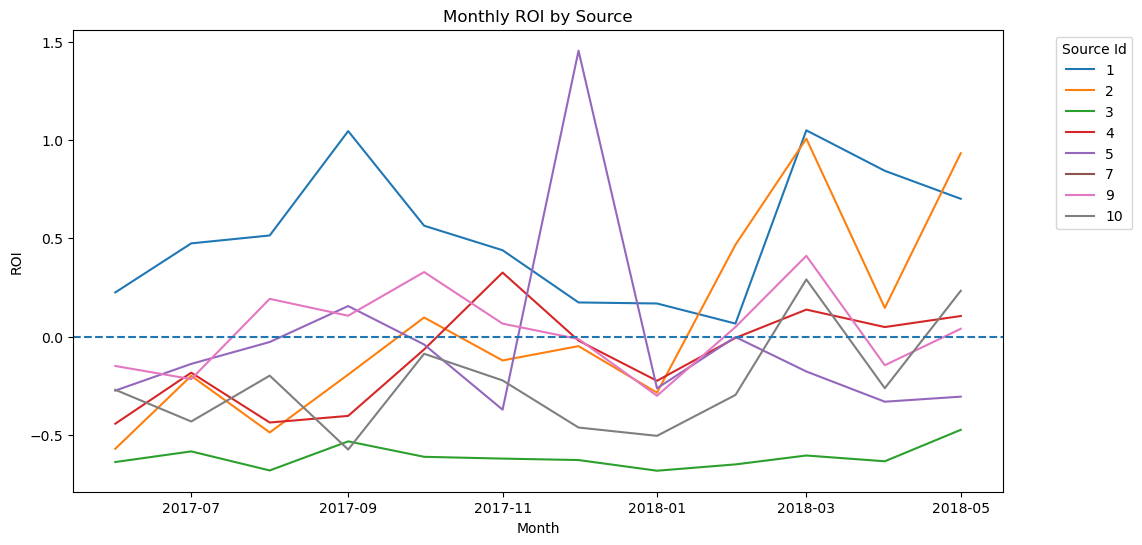

In [101]:
# Plot: Monthly ROI by source
plt.figure(figsize=(12,6))
for src, g in roi_month.sort_values('month').groupby('source_id'):
    plt.plot(g['month'], g['ROI'], label=str(src))
plt.title("Monthly ROI by Source")
plt.xlabel("Month")
plt.ylabel("ROI")
plt.axhline(0, linestyle='--')
plt.legend(title="Source Id", bbox_to_anchor=(1.05,1), loc='upper left')
plt.show()

In [102]:
# Cohort-based ROI & Payback

# Attribute each order to the user's cohort (cohort_month) and source
orders_attr = orders.merge(user_first_touch[['Uid','first_source','cohort_month']],on='Uid', how='left')
orders_attr['order_month'] = orders_attr['Buy Ts'].dt.to_period('M').dt.to_timestamp()


In [103]:
# Cohort age in months
orders_attr['age_months'] = (
(orders_attr['order_month'].dt.year - orders_attr['cohort_month'].dt.year) * 12 +(orders_attr['order_month'].dt.month - orders_attr['cohort_month'].dt.month))

In [104]:
# Revenue per (source, cohort_month, age)
rev_by_cohort = (orders_attr.groupby(['first_source','cohort_month','age_months'])['Revenue'].sum().reset_index().rename(columns={'first_source':'source_id'}))

In [105]:
# Acquisition cost per cohort (spend in cohort_month only)
spend_by_cohort = (costs.groupby(['source_id','month'])['costs'].sum().reset_index().rename(columns={'month':'cohort_month'}))

In [106]:
# Combine revenue & acquisition cost
roi_base = rev_by_cohort.merge(spend_by_cohort, on=['source_id','cohort_month'], how='left')

roi_base['costs'] = roi_base['costs'].fillna(0)

In [107]:
# Sort and compute cumulative revenue over cohort age
roi_base = roi_base.sort_values(['source_id','cohort_month','age_months'])

roi_base['cum_revenue'] = roi_base.groupby(['source_id','cohort_month'])['Revenue'].cumsum()

In [108]:
# Cohort ROI over age: cum_revenue / acquisition_cost - 1
roi_base['ROI'] = np.where(roi_base['costs']>0,roi_base['cum_revenue']/roi_base['costs'] - 1,np.nan)

In [109]:
# Payback month: first age_months where ROI >= 0
payback = (
    roi_base[roi_base['ROI']>=0].groupby(['source_id','cohort_month'])['age_months'].min().reset_index().rename(columns={'age_months':'payback_month'}))

In [110]:
display(payback.sort_values(['source_id','cohort_month']).head(10))

,source_id,cohort_month,payback_month
0,1,2017-06-01,0
1,1,2017-07-01,2
2,1,2017-08-01,3
3,1,2017-09-01,1
4,1,2017-10-01,1
5,2,2017-06-01,3
6,2,2017-07-01,5
7,2,2017-09-01,2
8,2,2017-12-01,2
9,4,2017-06-01,4


Saved: images\roi_curves_median.png


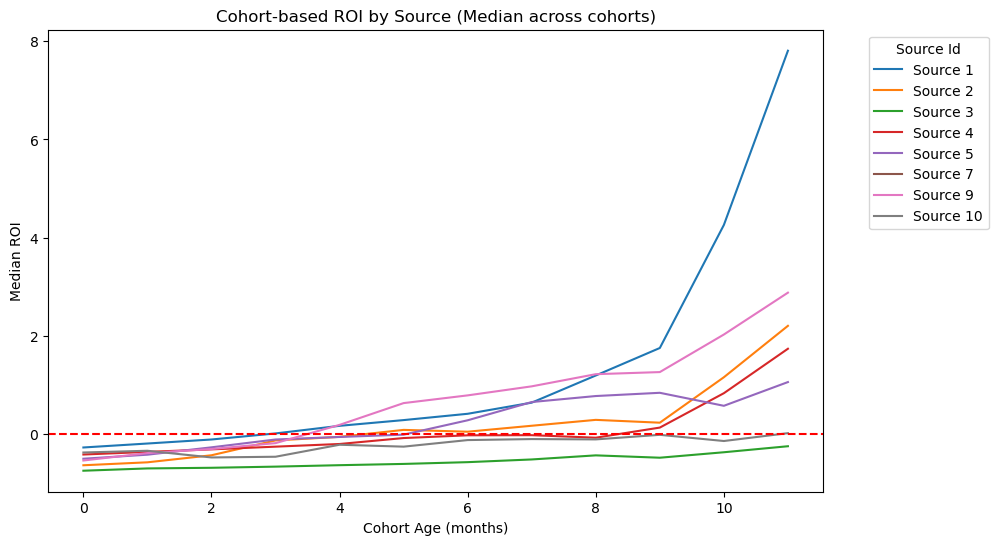

In [111]:
# Медианный ROI по возрасту для каждого источника
roi_avg = (
    roi_base.groupby(['source_id','age_months'])['ROI']
            .median()
            .reset_index()
)

plt.figure(figsize=(10,6))
for src, g in roi_avg.groupby('source_id'):
    plt.plot(g['age_months'], g['ROI'], label=f"Source {src}")

plt.title("Cohort-based ROI by Source (Median across cohorts)")
plt.xlabel("Cohort Age (months)")
plt.ylabel("Median ROI")
plt.axhline(0, linestyle='--', color='red')
plt.legend(title="Source Id", bbox_to_anchor=(1.05,1), loc='upper left')
save_plot("roi_curves_median.png")
plt.show()

### Interpretation — ROI

**Monthly ROI**
- Positive ROI (>0) in a given month means revenue exceeded spend for that period.
- Trends over time reveal whether channels are improving (learning effects, better targeting) or degrading (rising costs, weaker traffic).

**Cohort-based ROI & Payback**
- Cumulative ROI curves show how fast each cohort repays acquisition cost.
- **Payback month** is the first month where ROI ≥ 0:
  - Short payback (1–2 months): efficient, scalable channels.
  - Long payback (>6 months): risky unless justified by higher LTV and strategic goals.
- Comparing cohorts over time helps validate whether newer campaigns perform better than older ones.

**Recommendation**
- Prioritize channels with **fast payback** and **sustained positive ROI**.
- Monitor or reduce spend on channels with persistently negative ROI or very long payback, unless they support brand awareness with a clear long-term strategy.

## Final Project Conclusion — Marketing Recommendations

**1. How much money was spent?**  
- **Overall:** Total marketing spend ≈ 283k.  
- **By source:**  
  - Source 3: ~141k (≈ 50% of all spend)  
  - Source 4: ~61k  
  - Source 5: ~52k  
  - Source 2: ~43k  
  - Source 1: ~21k  
  - All others: <6k each  
- **Over time:** Spend was distributed unevenly, with noticeable peaks in mid-to-late 2017.

**2. How much did customer acquisition cost (CAC)?**  
- Source 1 consistently shows **very low CAC** (≈ $1.5–2.1 per new user).  
- Other sources have higher CAC (values not fully shown here), but generally above Source 1.  
- This suggests Source 1 is cost-efficient at driving user acquisition.

**3. How worthwhile were the investments? (ROI & Payback)**  
- **Source 1**:  
  - Fastest payback — some cohorts broke even immediately (0 months), others within 1–2 months.  
  - Indicates high-quality, quickly monetizing users.  
- **Source 2**:  
  - Payback slower (3–5 months).  
  - These users generate revenue but require longer retention to justify spend.  
- **Source 4**:  
  - Example cohort needed ~4 months to break even.  
- **Other sources (3, 5, etc.):** require further analysis, but given their high spend (esp. Source 3), ROI monitoring is critical.

### Recommended Actions
- **Increase investment** in **Source 1** — low CAC, fast payback, strong ROI.  
- **Maintain moderate investment** in **Source 2** — despite slower payback, it still delivers conversions; needs careful monitoring.  
- **Review Source 3 and 4** — high spend but slower payback → check if long-term LTV justifies investment.  
- **Deprioritize very small sources** unless they show unique strategic value.  

**Key Insight:**  
- The most efficient channel is **Source 1** — cheap acquisition, fast payback.  
- Sources 2 and 4 have potential but require longer horizon.  
- Source 3 consumes the biggest budget but must be justified with LTV analysis; otherwise, it risks being an inefficient allocation.

In [112]:
# Total spend per source
spend_summary = costs.groupby('source_id')['costs'].sum()

# Average CAC per source (ignore NaN)
cac_summary = cac.groupby('source_id')['CAC'].mean()

# Median payback month per source
payback_summary = payback.groupby('source_id')['payback_month'].median()

# Combine into one table
source_summary = (
    pd.concat([spend_summary, cac_summary, payback_summary], axis=1).rename(columns={'costs':'Total Spend', 'CAC':'Avg CAC', 'payback_month':'Median Payback (mo)'}).sort_values('Total Spend', ascending=False))

# Round values for readability
source_summary['Total Spend'] = source_summary['Total Spend'].round(2)
source_summary['Avg CAC'] = source_summary['Avg CAC'].round(2)

display(source_summary.head(5))

,Total Spend,Avg CAC,Median Payback (mo)
source_id,,,
3,141321.63,2.26,NaN
4,61073.60,0.89,4.0
5,51757.10,1.05,2.0
2,42806.04,2.19,2.5
1,20833.27,1.77,1.0


### Source Efficiency — Top 5 Channels

- **Source 3**  
  - Total Spend: ~141k (≈50% of total budget)  
  - Avg CAC: ~$2.26  
  - Payback: *not reached yet (NaN)*  
  - High spend but no clear payback → biggest risk channel.  

- **Source 4**  
  - Total Spend: ~61k  
  - Avg CAC: ~$0.89 (very low)  
  - Payback: ~4 months  
  - Efficient in terms of CAC, but slower payback → moderate attractiveness.  

- **Source 5**  
  - Total Spend: ~52k  
  - Avg CAC: ~$1.05  
  - Payback: ~2 months  
  - Good balance: reasonable spend, low CAC, relatively fast payback.  

- **Source 2**  
  - Total Spend: ~43k  
  - Avg CAC: ~$2.19  
  - Payback: ~2–3 months  
  - Mid-range efficiency: acceptable but more expensive than Source 5.  

- **Source 1**  
  - Total Spend: ~21k (smaller share of budget)  
  - Avg CAC: ~$1.77  
  - Payback: ~1 month  
  - Best performer: fast payback and reliable ROI, though underfunded compared to bigger channels.  

### Key Takeaway
- **Source 1 and Source 5** are the most efficient: low CAC and fast payback. They deserve *increased investment*.  
- **Source 4** has excellent CAC but slower payback — suitable for medium-term campaigns.  
- **Source 2** is borderline: higher CAC and slower payback, but still viable.  
- **Source 3** consumes half the budget but shows no payback → requires urgent ROI validation or budget reallocation.  
